<a href="https://colab.research.google.com/github/pedrobslima/projeto-ciencia-de-dados/blob/main/desmatamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Ciência de Dados

Pedro Barros de Souza Lima - pbsl@cin.ufpe.br

Dataset encontrado em: https://dados.gov.br/dados/conjuntos-dados/incendios-em-unidades-de-conservacao-federais



###**Objetivos:**

1. Coletar dados	✅

2.	Realizar pré-processamento dos dados:
  * Definição	de	tipos ✅
  * Tratamento	de	dados	ausentes ✅
  * Normalização	e	discretização
  * Limpeza	de	dados	(univariado,	bivariado	e	multivariado)

3.	Apresentar estatísticas descritivas	dos	dados com	visualizações

4.	Realizar teste	de	hipóteses para comparação de	valores	de	categorias	(ex.	preço	m2 em diferentes bairros)	e	visualizar diferenças
* Bônus:
  * Integrar	dados	ou extrair	dados	da	Web
  * Utilizar técnicas não cobertas nas aulas

### Imports

In [1]:
import requests
#from http.client import responses
#from os.path import dirname
#from os import environ
#import inspect
#import json
#import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from time import sleep

### Funções

In [2]:
def analiseTipos(df:pd.DataFrame, feature:str = None):
  '''Para printar uma contagem dos tipos, incluindo valores <NAN>
  Caso o parâmentro "feature" não seja declarado, será feito o .dtypes do dataframe "df"'''
  if(feature):
    print(f'''Num <NAN>: {len(df[df[feature].isna()])}

{df[feature].apply(lambda x: type(x)).value_counts()}''')
  else:
    print(f'Num <NAN>: {len(df[df.isna()])}\n')
    print(df.dtypes)

## Pré-análise dos dados

Coleta dos dados principais:

In [3]:
df = pd.read_excel('/content/tabela_de_desmatamento_ucs.xlsx', sheet_name=0, header=1)
df = df.drop(df.index[-1])
df = df.assign(bioma = "Amazônia")
for b in ['Mata Atlântica', 'Pampa', 'Cerrado', 'Caatinga']: # tirei o pantanal porque dados estavam incompletos
  temp = pd.read_excel('/content/tabela_de_desmatamento_ucs.xlsx', sheet_name=b, header=1)
  temp = temp.drop(temp.index[-1])
  temp = temp.assign(bioma = b)
  df = pd.concat([df, temp], ignore_index=True)

In [4]:
df.columns

Index([                  'cnuc', 'unidade de conservação',
                   'área_ha_uc',               'Até 2007',
                           2008,                     2009,
                           2010,                     2011,
                           2012,                     2013,
                           2014,                     2015,
                           2016,                     2017,
                           2018,                     2019,
                           2020,                     2021,
                           2022,                     2023,
                        'TOTAL',                  'bioma',
                     'Até 2000',            '2001 a 2004',
                           2006,                     2002,
                           2004],
      dtype='object')

---
### Verificação da coluna 'TOTAL' e remoção de registros pré-2008


In [5]:
cols = ['Até 2007', 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023, 'Até 2000', '2001 a 2004', 2006, 2002, 2004]

df.assign(total_check=lambda x: x.loc[:,cols].sum(axis=1))[['unidade de conservação', 'bioma', 'TOTAL', 'total_check']]

,unidade de conservação,bioma,TOTAL,total_check
0,APA do Igarapé Gelado,Amazônia,9146.70,9146.70
1,APA do Tapajós,Amazônia,137537.01,137537.01
2,APA dos Campos de Manicoré,Amazônia,215.43,215.43
3,ARIE Projeto Dinâmica Biológica de Fragmento F...,Amazônia,74.26,74.26
4,ARIE Seringal Nova Esperança,Amazônia,1777.85,1777.85
...,...,...,...,...
316,REBIO Guaribas,Caatinga,20.16,20.16
317,RESEX do Batoque,Caatinga,105.36,105.36
318,RESEX Prainha do Canto Verde,Caatinga,72.90,72.90
319,REVIS da Ararinha Azul,Caatinga,111.72,111.72


Se você for comparar os valores da soma e do TOTAL, pelo pandas vai dizer que alguns não são iguais, mas se compararmos visualmente, claramente não há diferença. Provavelmente é uma diferença na leitura dos floats ou na computação da soma. Não há diferenças relevantes.

In [6]:
df = df.drop(columns=['Até 2007', '2001 a 2004', 'Até 2000', 2002, 2006, 2004])

In [7]:
df

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
0,0000.00.0022,APA do Igarapé Gelado,2.071467e+04,119.53,0.00,5.15,0.00,0.00,10.63,0.00,...,0.09,0.00,0.00,9.81,23.75,7.68,14.29,0.00,9146.70,Amazônia
1,0000.00.0268,APA do Tapajós,2.040336e+06,1648.94,1523.54,829.74,1352.57,2238.81,3246.37,2872.94,...,3143.69,3229.61,3895.20,6552.78,6963.76,10646.08,11140.01,4879.10,137537.01,Amazônia
2,0000.00.3407,APA dos Campos de Manicoré,1.521325e+05,0.00,24.53,4.32,16.52,0.00,0.00,0.00,...,11.59,26.83,11.19,40.52,0.00,20.45,29.66,1.71,215.43,Amazônia
3,0000.00.0043,ARIE Projeto Dinâmica Biológica de Fragmento F...,3.336296e+03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74.26,Amazônia
4,0000.00.0044,ARIE Seringal Nova Esperança,2.573984e+03,13.01,25.32,28.75,34.40,222.00,26.89,132.50,...,78.45,61.09,55.34,70.91,57.78,119.10,61.31,90.59,1777.85,Amazônia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,0000.00.0196,REBIO Guaribas,4.051657e+03,0.39,NaN,0.00,0.00,NaN,0.00,0.00,...,0.11,0.00,0.00,0.00,0.00,0.00,0.00,NaN,20.16,Caatinga
317,0000.00.0231,RESEX do Batoque,6.014409e+02,0.00,NaN,14.70,0.00,NaN,5.94,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,105.36,Caatinga
318,0000.00.1809,RESEX Prainha do Canto Verde,2.980527e+04,0.00,NaN,30.13,0.00,NaN,0.00,0.00,...,2.89,0.00,0.00,12.68,0.00,0.00,0.00,NaN,72.90,Caatinga
319,0000.00.3694,REVIS da Ararinha Azul,2.923449e+04,7.68,NaN,17.78,0.00,NaN,19.26,9.08,...,3.65,0.00,0.00,6.27,4.79,3.23,0.00,NaN,111.72,Caatinga


---
### Verificação de Unidades de Conservação (UC) duplicadas

In [8]:
(df['unidade de conservação'].value_counts() > 1).sum()

17

In [9]:
cols = ['unidade de conservação', 'bioma']
df.loc[:,cols].groupby(by='unidade de conservação').aggregate('count').sort_values(by='bioma', ascending=False).head(18)

,bioma
unidade de conservação,
PARNA Cavernas do Peruaçu,2
APA das Ilhas e Várzeas do Rio Paraná,2
PARNA Serra de Itabaiana,2
RESEX do Ciriaco,2
APA da Barra do Rio Mamanguape,2
REBIO Guaribas,2
PARNA de Boa Nova,2
FLONA de Capão Bonito,2
PARNA da Serra das Confusões,2


UCs repetidas são compostas por 2 biomas.

In [10]:
df.head()

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
0,0000.00.0022,APA do Igarapé Gelado,2.071467e+04,119.53,0.00,5.15,0.00,0.00,10.63,0.00,...,0.09,0.00,0.00,9.81,23.75,7.68,14.29,0.00,9146.70,Amazônia
1,0000.00.0268,APA do Tapajós,2.040336e+06,1648.94,1523.54,829.74,1352.57,2238.81,3246.37,2872.94,...,3143.69,3229.61,3895.20,6552.78,6963.76,10646.08,11140.01,4879.10,137537.01,Amazônia
2,0000.00.3407,APA dos Campos de Manicoré,1.521325e+05,0.00,24.53,4.32,16.52,0.00,0.00,0.00,...,11.59,26.83,11.19,40.52,0.00,20.45,29.66,1.71,215.43,Amazônia
3,0000.00.0043,ARIE Projeto Dinâmica Biológica de Fragmento F...,3.336296e+03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74.26,Amazônia
4,0000.00.0044,ARIE Seringal Nova Esperança,2.573984e+03,13.01,25.32,28.75,34.40,222.00,26.89,132.50,...,78.45,61.09,55.34,70.91,57.78,119.10,61.31,90.59,1777.85,Amazônia


In [11]:
#cols = ['unidade de conservação', 'TOTAL', 'bioma']
#df.loc[:,cols].groupby(by=['unidade de conservação', 'TOTAL']).aggregate('count').sort_values(by='bioma', ascending=False).head(18)
df[df['unidade de conservação'] == 'PARNA Cavernas do Peruaçu']

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
259,0000.00.0135,PARNA Cavernas do Peruaçu,56448.64549,8.68,NaN,26.68,NaN,75.26,7.09,1.01,...,0.00,10.12,12.59,0.00,0.0,0.00,0.0,NaN,907.26,Cerrado
303,0000.00.0135,PARNA Cavernas do Peruaçu,56448.64549,142.74,NaN,86.69,4.96,NaN,241.22,82.60,...,78.57,41.40,61.49,13.29,5.1,15.49,0.0,NaN,3494.64,Caatinga


É importante deixá-las como instâncias separadas porque a área desmatada é diferente entre biomas da mesma UC.

---
### Coleta & Integração das Unidades Federativas ao dataset principal
(+ rápida análise + remoção de duplicatas)


In [12]:
dfid = pd.read_excel('/content/dados-do-samge-1-identificacao-e-resultados.xlsx').loc[:,['Nome da UC', 'UF']]

In [13]:
dfid.head()

,Nome da UC,UF
0,APA ANHATOMIRIM,SC
1,APA CAVERNAS DO PERUAÇU,MG
2,APA DA BACIA DO RIO DESCOBERTO,"DF, GO"
3,APA DA BACIA DO RIO SÃO BARTOLOMEU,DF
4,APA DA BACIA DO RIO SÃO JOÃO - MICO LEÃO,RJ


In [14]:
dfid['Nome da UC'].value_counts()

Nome da UC
FLONA DE TRÊS BARRAS            6
PARNA DE BRASÍLIA               6
PARNA DE ILHA GRANDE            6
PARNA DE SAINT-HILAIRE/LANGE    6
PARNA DE SÃO JOAQUIM            6
                               ..
APA BAÍA NEGRA                  1
FE DO RIO LIBERDADE             1
FE DO RIO GREGÓRIO              1
FE DO MOGNO                     1
PNM FAZENDA DO CARMO            1
Name: count, Length: 779, dtype: int64

In [15]:
dfid[dfid['Nome da UC'] == 'FLONA DE TRÊS BARRAS']

,Nome da UC,UF
124,FLONA DE TRÊS BARRAS,SC
769,FLONA DE TRÊS BARRAS,SC
1415,FLONA DE TRÊS BARRAS,SC
1951,FLONA DE TRÊS BARRAS,SC
2459,FLONA DE TRÊS BARRAS,SC
2774,FLONA DE TRÊS BARRAS,SC


In [16]:
print(len(dfid))
len(dfid.drop_duplicates())

2907


779

Não foi apresentado aqui no código, mas na planilha original, a diferença entre essas duplicatas são apenas o ano do registro, que é importante para dados referentes ao gerenciamento das UCs.

Como nós só precisamos do(s) estado(s) onde estão localizadas, não tem porquê manter essas duplicatas:  

In [17]:
dfid = dfid.drop_duplicates()
df['unidade de conservação'] = df['unidade de conservação'].apply(lambda x: x.upper())
df = pd.merge(df, dfid, how='inner', right_on='Nome da UC', left_on='unidade de conservação').drop(columns=['Nome da UC'])
df[df['unidade de conservação'] == 'APA DA BACIA DO RIO DESCOBERTO']

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma,UF
168,0000.00.0003,APA DA BACIA DO RIO DESCOBERTO,36159.770194,121.38,NaN,81.63,NaN,48.05,25.85,241.22,...,47.46,39.52,6.13,16.94,29.47,10.97,NaN,29053.02,Cerrado,"DF, GO"


---
### Definição de tipos

In [18]:
df.dtypes

cnuc                       object
unidade de conservação     object
área_ha_uc                float64
2008                      float64
2009                      float64
2010                      float64
2011                      float64
2012                      float64
2013                      float64
2014                      float64
2015                      float64
2016                      float64
2017                      float64
2018                      float64
2019                      float64
2020                      float64
2021                      float64
2022                      float64
2023                      float64
TOTAL                     float64
bioma                      object
UF                         object
dtype: object

In [19]:
df['cnuc'].nunique() == df['unidade de conservação'].nunique()

True

In [20]:
print(df['UF'].unique())
df['UF'].nunique()

['PA' 'AM' 'AC' 'AM, RO' 'RR' 'AP, PA' 'RO' 'AM, PA' 'AP' 'AM, MT'
 'AM, MT, RO' 'AM, RR' 'MA' 'SC' 'ES' 'RJ' 'PR' 'MG' 'SP' 'RS' 'AL' 'RN'
 'SE' 'RJ, SP' 'BA' 'RS, SC' 'MS, PR' 'AL, PE' 'PE' 'PB' 'DF, GO' 'DF'
 'GO' 'CE, PI' 'TO' 'MT' 'PI' 'BA, TO' 'MS' 'CE']


40

In [21]:
print(df.loc[:,'UF'][df['UF'].str.len() == 2].unique())
df.loc[:,'UF'][df['UF'].str.len() == 2].nunique()

['PA' 'AM' 'AC' 'RR' 'RO' 'AP' 'MA' 'SC' 'ES' 'RJ' 'PR' 'MG' 'SP' 'RS'
 'AL' 'RN' 'SE' 'BA' 'PE' 'PB' 'DF' 'GO' 'TO' 'MT' 'PI' 'MS' 'CE']


27

Todos os estados estão listados

In [26]:
df.loc[:,'UF'][df['UF'].str.len() > 2].value_counts()

UF
DF, GO        4
AM, RO        2
AP, PA        2
RS, SC        2
CE, PI        2
AM, PA        1
AM, MT        1
AM, MT, RO    1
AM, RR        1
RJ, SP        1
MS, PR        1
AL, PE        1
BA, TO        1
Name: count, dtype: int64

In [79]:
co = ['AL', 'PE', 'PB', 'RN', 'SE', 'CE', 'PI', 'MA', 'BA', # NE  (1) 0-8
      'TO', 'PA', 'AC', 'RR', 'RO', 'AP', 'AM',             # N   (1) 9-15
      'MT', 'MS', 'DF', 'GO',                               # CO  (1) 16-19
      'PR', 'RS', 'SC',                                     # S   (1) 20-22
      'ES', 'RJ', 'MG', 'SP',                               # SE  (1) 23-26
      'AL, PE', 'CE, PI',                     # NE      (2) 27-28
      'BA, TO',                               # NE, N   (2) 29
      'AM, RO', 'AM, PA', 'AM, RR', 'AP, PA', # N       (2) 30-33
      'AM, MT', 'AM, MT, RO',                 # N, CO   (2)(3) 34-35
      'DF, GO',                               # CO      (2) 36
      'MS, PR',                               # CO, S   (2) 37
      'RS, SC',                               # S       (2) 38
      'RJ, SP'                                # SE      (2) 39
      ]

df['UF'] = df['UF'].astype(pd.api.types.CategoricalDtype(categories=co))

Não acho que vale a pena aumentar o número de UCs para que cada instância tenha apenas uma UF relacionada. Elas já foram dividas de acordo com seus biomas, além disso, não temos como relacionar um bioma a um estado exclusivamente porque biomas não respeitam fronteiras artificiais.

In [23]:
df['bioma'].unique(), df['bioma'].nunique()

(array(['Amazônia', 'Cerrado', 'Mata Atlântica', 'Caatinga', 'Pampa'],
       dtype=object),
 5)

In [24]:
df['bioma'] = df['bioma'].astype('category')
df['bioma'].cat.categories

Index(['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica', 'Pampa'], dtype='object')

In [25]:
#df['bioma'] = df['bioma'].cat.codes

Criação da coluna "região":

In [75]:
df[df['UF'].isin(['BA, TO', 'AM, MT', 'AM, MT, RO', 'MS, PR'])]

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2018,2019,2020,2021,2022,2023,TOTAL,bioma,UF,região
43,0000.00.0281,PARNA DO JURUENA,1.957028e+06,363.50,0.00,62.79,79.32,7.30,35.90,0.00,...,10.09,48.89,38.14,70.40,41.94,99.16,10948.16,Amazônia,"AM, MT","N, CO"
47,0000.00.0284,PARNA DOS CAMPOS AMAZÔNICOS,9.613137e+05,385.13,71.51,17.94,139.62,48.76,192.89,0.00,...,37.75,197.04,514.00,735.05,363.06,182.31,7015.26,Amazônia,"AM, MT, RO","N, CO"
132,0000.00.0161,PARNA DE ILHA GRANDE,7.613765e+04,31.33,NaN,0.00,9.25,NaN,18.49,0.00,...,4.85,12.09,8.09,0.00,14.80,NaN,362.80,Mata Atlântica,"MS, PR","CO, S"
178,0000.00.0076,ESEC SERRA GERAL DO TOCANTINS,7.070848e+05,289.34,NaN,4.64,NaN,10.33,30.61,115.32,...,0.00,1.19,16.96,6.94,2.38,NaN,2136.71,Cerrado,"BA, TO","NE, N"


Apenas 4 UCs estão presentes em mais de uma região.

In [105]:
uf2reg = ['NE', 'N', 'CO', 'S', 'SE', 'NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = pd.cut(df.UF.cat.codes, [0, 9, 16, 20, 23, 27, 29, 30, 34, 36, 37, 38, 39, 40], ordered=False, labels=uf2reg, right=False)

# Define and apply arbitrary category order
# Essa ordem foi decidida porque se quiser fazer uma análise de bioma presentes
# nas regiões, por exemplo, Norte e/ou Centro-Oeste, é só especificar o intervalo
# dos índices de ambas as regiões, que também irá incluir UCs presentes em ambas
# ao mesmo tempo, df['região'].cat.categories[1:4] => ['N', 'N, CO', 'CO'],
# ou até df['região'].cat.categories[3:6] => ['N', 'N, CO', 'CO']
co = ['NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = df['região'].astype(pd.api.types.CategoricalDtype(categories=co))

df['região'].value_counts()

região
N        82
NE       57
SE       38
S        27
CO       12
N, CO     2
CO, S     1
NE, N     1
Name: count, dtype: int64

In [106]:
df[df['região'].isin(df['região'].cat.categories[3:6])]

,cnuc,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,...,2018,2019,2020,2021,2022,2023,TOTAL,bioma,UF,região
43,0000.00.0281,PARNA DO JURUENA,1.957028e+06,363.50,0.00,62.79,79.32,7.30,35.90,0.00,...,10.09,48.89,38.14,70.40,41.94,99.16,10948.16,Amazônia,"AM, MT","N, CO"
47,0000.00.0284,PARNA DOS CAMPOS AMAZÔNICOS,9.613137e+05,385.13,71.51,17.94,139.62,48.76,192.89,0.00,...,37.75,197.04,514.00,735.05,363.06,182.31,7015.26,Amazônia,"AM, MT, RO","N, CO"
55,0000.00.0207,REBIO DO GURUPI,2.714651e+05,3648.27,2761.69,1161.74,666.21,833.65,663.34,50.21,...,368.14,315.77,338.75,495.03,445.94,313.98,82307.54,Amazônia,MA,NE
62,0000.00.3654,RESEX ARAPIRANGA-TROMAÍ,1.869363e+05,0.00,0.00,0.00,0.00,9.35,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,NaN,2248.02,Amazônia,MA,NE
69,0000.00.3653,RESEX DA BAÍA DO TUBARÃO,2.239274e+05,2.83,1.16,0.71,0.00,0.00,1.45,18.43,...,6.63,12.56,21.23,9.06,0.00,NaN,186.91,Amazônia,MA,NE
70,0000.00.3653,RESEX DA BAÍA DO TUBARÃO,2.239274e+05,0.00,NaN,0.12,NaN,0.00,0.00,7.70,...,0.00,0.00,2.56,2.52,0.00,NaN,217.22,Cerrado,MA,NE
71,0000.00.0279,RESEX DE CURURUPU,1.860535e+05,26.70,2.32,0.00,0.00,0.00,0.00,4.10,...,0.00,0.00,0.00,0.00,0.00,NaN,20841.41,Amazônia,MA,NE
75,0000.00.3651,RESEX ITAPETININGA,1.629402e+04,0.00,7.65,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,NaN,4634.92,Amazônia,MA,NE
99,0000.00.0059,ESEC DE MURICI,6.131573e+03,175.01,NaN,171.16,0.80,NaN,23.63,0.00,...,1.63,1.77,9.33,4.24,0.00,NaN,959.88,Mata Atlântica,AL,NE
111,0000.00.0100,FLONA DE NÍSIA FLORESTA,1.688443e+02,0.00,NaN,0.00,0.00,NaN,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,NaN,0.20,Mata Atlântica,RN,NE


---
###Tratamento de dados ausentes

In [107]:
cols = ['unidade de conservação', 'área_ha_uc', 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 'TOTAL', 'bioma']
df[cols].head()

,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
0,APA DO IGARAPÉ GELADO,2.071467e+04,119.53,0.00,5.15,0.00,0.00,10.63,0.00,0.00,0.09,0.00,0.00,9.81,23.75,7.68,14.29,0.00,9146.70,Amazônia
1,APA DO TAPAJÓS,2.040336e+06,1648.94,1523.54,829.74,1352.57,2238.81,3246.37,2872.94,3437.89,3143.69,3229.61,3895.20,6552.78,6963.76,10646.08,11140.01,4879.10,137537.01,Amazônia
2,APA DOS CAMPOS DE MANICORÉ,1.521325e+05,0.00,24.53,4.32,16.52,0.00,0.00,0.00,0.00,11.59,26.83,11.19,40.52,0.00,20.45,29.66,1.71,215.43,Amazônia
3,ARIE SERINGAL NOVA ESPERANÇA,2.573984e+03,13.01,25.32,28.75,34.40,222.00,26.89,132.50,89.38,78.45,61.09,55.34,70.91,57.78,119.10,61.31,90.59,1777.85,Amazônia
4,ESEC ALTO MAUÉS,6.665559e+05,0.00,16.64,31.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,45.94,5.56,33.46,145.82,56.26,524.67,Amazônia


In [108]:
df.loc[(df[cols].isna().any(axis=1)), cols]

,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
48,PARNA DOS CAMPOS FERRUGINOSOS,7.886933e+04,199.46,0.00,13.55,0.00,0.0,0.00,26.16,0.03,105.10,13.18,26.81,0.00,0.00,1.85,0.0,NaN,7084.51,Amazônia
50,PARNA MONTANHAS DO TUMUCUMAQUE,3.865169e+06,0.00,0.00,23.58,0.00,0.0,0.00,0.00,6.67,0.00,9.24,0.00,28.09,20.45,43.28,0.0,NaN,4187.83,Amazônia
51,PARNA NASCENTES DO LAGO JARI,8.085987e+05,0.00,7.52,0.00,9.96,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,2.80,0.00,0.0,NaN,2770.26,Amazônia
52,PARNA SERRA DA MOCIDADE,3.593701e+05,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,9.07,Amazônia
53,REBIO DO ABUFARI,2.247450e+05,13.39,0.00,69.70,8.53,0.0,18.99,13.84,0.00,10.20,0.00,0.00,0.00,6.39,0.00,0.0,NaN,347.46,Amazônia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,PARNA DO CATIMBAU,6.229488e+04,195.94,NaN,131.77,19.43,NaN,83.71,27.20,NaN,22.05,137.16,34.73,11.34,19.90,25.44,29.1,NaN,12020.38,Caatinga
216,REBIO DE SERRA NEGRA,6.248539e+02,0.00,NaN,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,3.81,Caatinga
217,RESEX DO BATOQUE,6.014409e+02,0.00,NaN,14.70,0.00,NaN,5.94,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,105.36,Caatinga
218,RESEX PRAINHA DO CANTO VERDE,2.980527e+04,0.00,NaN,30.13,0.00,NaN,0.00,0.00,NaN,2.89,0.00,0.00,12.68,0.00,0.00,0.0,NaN,72.90,Caatinga


In [109]:
df[df['bioma'].cat.codes==1].loc[:,cols]

,unidade de conservação,área_ha_uc,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,TOTAL,bioma
131,PARNA DE BOA NOVA,1.229458e+04,120.50,NaN,28.53,0.00,NaN,63.27,23.42,NaN,21.24,20.36,3.86,16.58,0.00,0.00,0.00,NaN,1568.86,Caatinga
154,REBIO GUARIBAS,4.051657e+03,0.39,NaN,0.00,0.00,NaN,0.00,0.00,NaN,0.11,0.00,0.00,0.00,0.00,0.00,0.00,NaN,20.16,Caatinga
160,REVIS DE BOA NOVA,1.483345e+04,32.18,NaN,14.57,0.00,NaN,1.31,0.00,NaN,27.94,0.00,0.00,1.53,0.00,0.00,12.59,NaN,1670.72,Caatinga
167,APA CAVERNAS DO PERUAÇU,1.152097e+05,71.32,NaN,155.47,0.00,NaN,222.36,25.47,NaN,75.00,1.86,7.49,9.25,10.51,15.40,1.70,NaN,6192.45,Caatinga
173,APA SERRA DA IBIAPABA,1.622418e+06,15344.82,NaN,19106.54,3364.89,NaN,6512.01,3857.47,NaN,4776.62,4106.88,1914.27,2076.97,2014.73,2291.21,2430.24,NaN,241266.31,Caatinga
183,PARNA CAVERNAS DO PERUAÇU,5.644865e+04,142.74,NaN,86.69,4.96,NaN,241.22,82.60,NaN,78.57,41.40,61.49,13.29,5.10,15.49,0.00,NaN,3494.64,Caatinga
198,APA DA ARARINHA AZUL,9.064078e+04,46.90,NaN,1.64,2.36,NaN,70.91,1.31,NaN,17.81,3.67,21.90,37.33,7.09,18.62,53.29,NaN,897.56,Caatinga
199,APA DO BOQUEIRÃO DA ONÇA,5.056454e+05,558.16,NaN,126.73,792.08,NaN,297.65,96.47,NaN,206.82,108.89,292.01,123.65,106.28,1203.61,903.17,NaN,41967.69,Caatinga
200,APA SERRA DA MERUOCA,2.936154e+04,421.69,NaN,277.00,39.83,NaN,248.37,145.75,NaN,154.37,78.22,13.25,34.78,9.11,15.57,47.87,NaN,6676.99,Caatinga
201,ESEC DE AIUABA,1.174692e+04,24.68,NaN,19.65,9.41,NaN,14.57,1.45,NaN,17.01,7.44,14.92,9.80,52.89,2.71,6.22,NaN,972.82,Caatinga


In [ ]:
df.loc[:,2023].isna().sum() / len(df)

0.7181818181818181

Aproximadamente 72% dos registros de 2023 são nulos, será que devo remover?

Colunas NAN por biomas:
* Amazônia:
  * Any NAN: 2023 (25NAN x 62NUM)
  * All NAN:
* Caatinga:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Cerrado:
  * Any NAN: 2009, 2011, 2023
  * All NAN: 2009, 2011, 2023
* Mata Atlântica:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Pampa:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023

In [ ]:
pd.isna(df.loc[70, 2009])

True

In [ ]:
df.loc[(((df.bioma.cat.codes==1) | (df.bioma.cat.codes==4))), cols].index == df.loc[((df[cols].isna().any(axis=1)) & ((df.bioma.cat.codes==1) | (df.bioma.cat.codes==4))), cols].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
cols = [2009, 2012, 2015]
df.loc[((df.bioma.cat.codes==1) | (df.bioma.cat.codes==4)), cols] = df.loc[((df.bioma.cat.codes==1) | (df.bioma.cat.codes==4)), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
cols = [2009, 2011]
df.loc[(df.bioma.cat.codes==2), cols] = df.loc[(df.bioma.cat.codes==2), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
#df = df.drop(columns=[2023])

<Axes: >

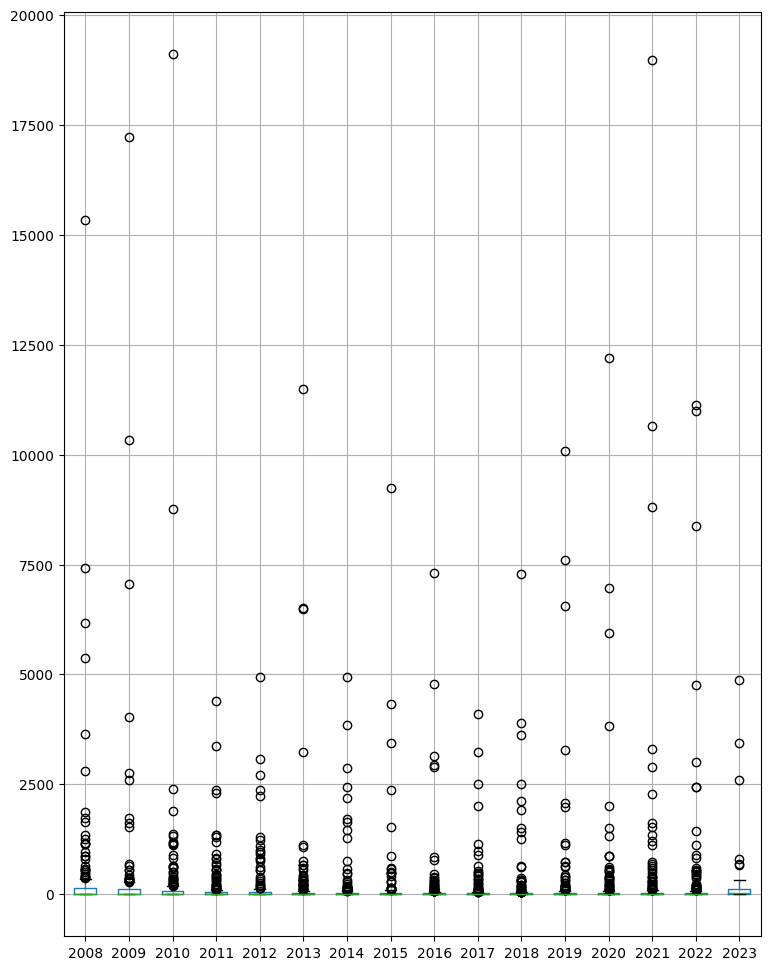

In [ ]:
df[range(2008,2024)].boxplot(figsize=(9,12))

<Axes: >

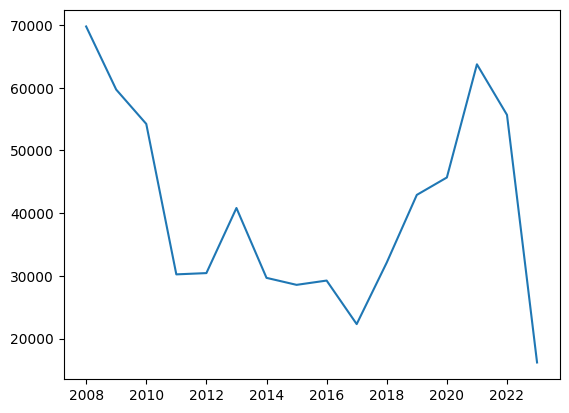

In [ ]:
cols = range(2008,2024)
df[cols].sum().plot.line()

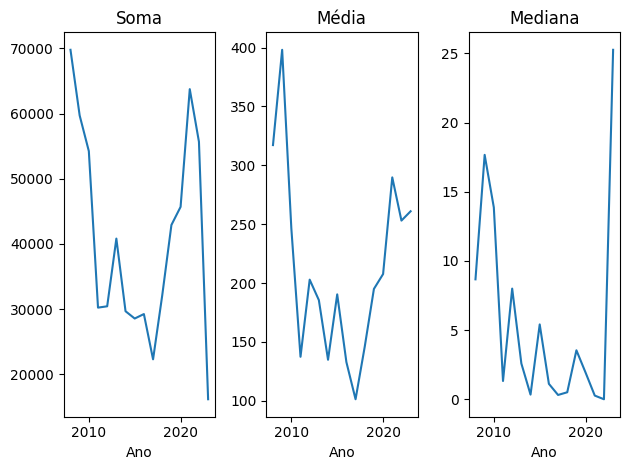

In [ ]:
plt.subplot(1, 3, 1)
plt.title('Soma')
plt.xlabel('Ano')
plt.plot(df[cols].sum())

plt.subplot(1, 3, 2)
plt.title('Média')
plt.xlabel('Ano')
plt.plot(df[cols].mean())

plt.subplot(1, 3, 3)
plt.title('Mediana')
plt.xlabel('Ano')
plt.plot(df[cols].median())

plt.tight_layout()
plt.show()

<Axes: >

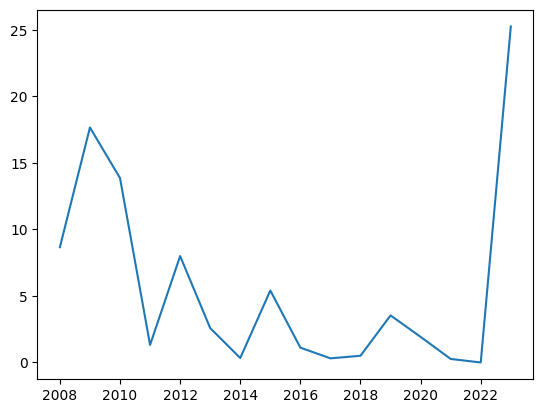

In [ ]:
df[cols].median().plot.line()

<Axes: >

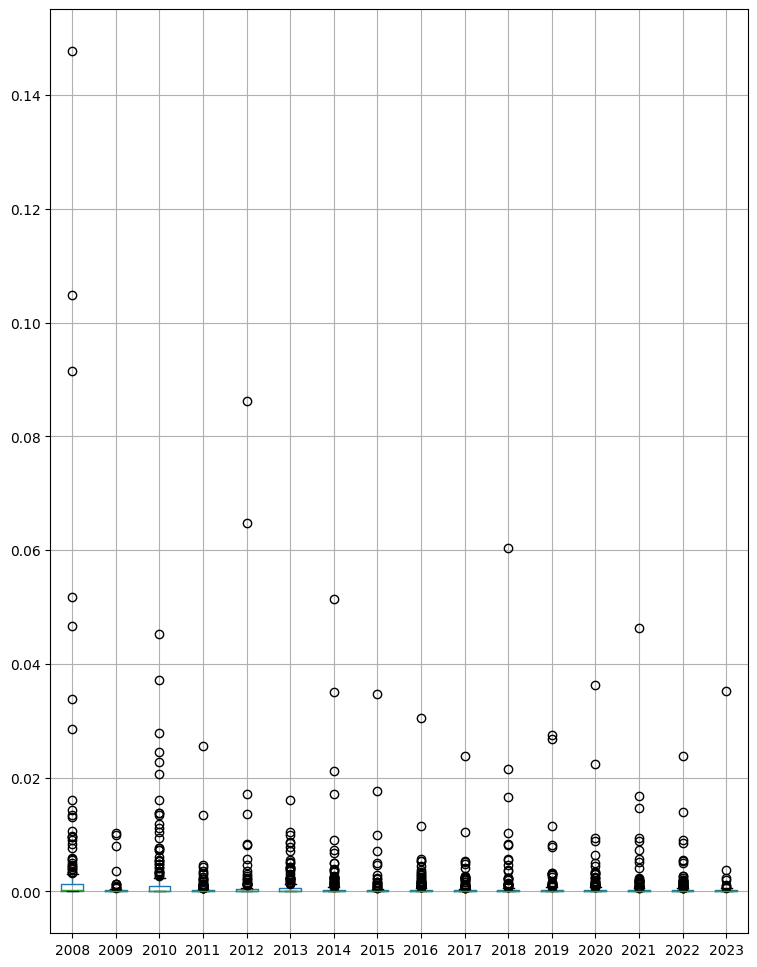

In [ ]:
dft = df.copy()
dft.loc[:,range(2008,2024)] = dft.loc[:,range(2008,2024)].apply(lambda x: x/dft['área_ha_uc'])
dft[range(2008,2024)].boxplot(figsize=(9,12))

## Pré-análise dos dados (ANTIGO TAMBÉM)

In [ ]:
dfesp = pd.read_csv("/content/especime_apreendido.csv", sep='\t')

<ipython-input-2-3d80e5232d97>:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfesp = pd.read_csv("/content/especime_apreendido.csv", sep='\t')


In [ ]:
dfespog = dfesp.copy() # caso precise fazer consultas na versão original depois de modificar o dataset

In [ ]:
dfter = pd.read_csv("/content/termo_apreensao.csv", sep=";")

<ipython-input-5-a97b1bcf1c56>:1: DtypeWarning: Columns (0,3,6,9,10,27,30) have mixed types. Specify dtype option on import or set low_memory=False.
  dfter = pd.read_csv("/content/termo_apreensao.csv", sep=";")


In [ ]:
print(dfter.columns[0]+"\n"+dfter.columns[3]+"\n"+dfter.columns[6]+"\n"+dfter.columns[9]+"\n"+dfter.columns[27]+"\n"+dfter.columns[30])

SEQ_TAD
NUM_TAD
DAT_IMPRESSAO
CPF_CNPJ_PESSOA_APREENSAO
NUM_ORDEM_FISCALIZACAO
OPERACAO_SOL_RECURSO


In [ ]:
dfesp.columns[13]

'DAT_ALTERACAO'

In [ ]:
dfesp.head()

,SEQ_TAD,SEQ_ESPECIME_APREENDIDO,QTD_ESPECIME_APREENDIDO,DES_UNIDADE_MEDIDA,DESCRICAO_PRODUTO,SITUACAO_CARACTERISTICA,TIPO,GRUPO,SEQ_TAXONOMIA,NOME_CIENTIFICO,DES_NOME_POPULAR,CITES,OBSERVACAO,DAT_ALTERACAO,ULTIMA_ATUALIZACAO_RELATORIO
0,1845325,821088,"1,74",m³ (1 MDC),Espécime,Morta,NaN,NaN,34198.0,Dipteryx odorata,NaN,NaN,NaN,NaN,18/05/2024 19:01
1,1845325,821089,"10,31",m³ (1 MDC),Espécime,Morta,NaN,NaN,32970.0,Dipteryx polyphylla,NaN,NaN,NaN,NaN,18/05/2024 19:01
2,1845325,821090,"1,05",m³ (1 MDC),Espécime,Morta,NaN,NaN,32930.0,Cedrela odorata,NaN,NaN,NaN,NaN,18/05/2024 19:01
3,1845319,821087,1,Unidade,Espécime,Viva,NaN,NaN,6427.0,Oryzoborus angolensis,NaN,NaN,NaN,NaN,18/05/2024 19:01
4,1845318,821086,1,Unidade,Espécime,Viva,NaN,NaN,6427.0,Oryzoborus angolensis,NaN,NaN,NaN,NaN,18/05/2024 19:01


In [ ]:
dfter.head()

,SEQ_TAD,STATUS_FORMULARIO,SIT_CANCELADO,NUM_TAD,SER_TAD,DAT_TAD,DAT_IMPRESSAO,NUM_PESSOA_APREENSAO,NOM_PESSOA_APREENSAO,CPF_CNPJ_PESSOA_APREENSAO,...,NOM_OPERACAO,SEQ_ORDEM_FISCALIZACAO,NUM_ORDEM_FISCALIZACAO,SEQ_SOLICITACAO_RECURSO,NUM_SOLICITACAO_RECURSO,OPERACAO_SOL_RECURSO,DAT_ALTERACAO,TIPO_ALTERACAO,JUSTIFICATIVA_ALTERACAO,ULTIMA_ATUALIZACAO_RELATORIO
0,1782411,Lavrado,N,371040,C,3005-03-18 16:20:00,NaN,1241919.0,JOSE SANTANA MOTA,23283190500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-06 17:15:53,Preenchido,TAD Cadastrado,22/05/2024 19:01
1,1465404,Lavrado,N,33353,E,2080-09-01 08:47:17,2080-09-01 09:20:14,236567.0,MUNICIPIO DE JOÃO PESSOA,8806721000103.0,...,NaN,2613087.0,PB033791,NaN,NaN,NaN,2016-06-09 15:49:09,NaN,NaN,22/05/2024 19:01
2,144855,Lavrado,N,384670,C,2051-06-03 14:20:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-01 15:01:21,Preenchido,TAD Cadastrado,22/05/2024 19:01
3,1841246,Lavrado,N,WFPLW5SL,NaN,2024-11-30 17:27:41,NaN,8556848.0,Thiago da Silva Lima,3793467295.0,...,NaN,7786608.0,AM076560,51324.0,51324.2023,BANZEIRO,2024-03-07 15:55:07,Alterado,(Migração AI-e) TAD Alterado,22/05/2024 19:01
4,1841245,Lavrado,N,GDLQ1VZX,NaN,2024-11-30 16:55:41,NaN,8556848.0,Thiago da Silva Lima,3793467295.0,...,NaN,7786608.0,AM076560,51324.0,51324.2023,BANZEIRO,2024-03-07 15:55:06,Alterado,(Migração AI-e) TAD Alterado,22/05/2024 19:01


NaN = Not a Number

NaT = Not a Time

In [ ]:
print(len(dfesp))
len(dfter)

138742


151699

In [ ]:
df = pd.merge(dfesp, dfter, how='inner', on='SEQ_TAD')

In [ ]:
len(df)

42293

In [ ]:
df.dtypes

SEQ_TAD                            object
SEQ_ESPECIME_APREENDIDO             int64
QTD_ESPECIME_APREENDIDO            object
DES_UNIDADE_MEDIDA                 object
DESCRICAO_PRODUTO                  object
SITUACAO_CARACTERISTICA            object
TIPO                               object
GRUPO                              object
SEQ_TAXONOMIA                     float64
NOME_CIENTIFICO                    object
DES_NOME_POPULAR                   object
CITES                              object
OBSERVACAO                         object
DAT_ALTERACAO_x                    object
ULTIMA_ATUALIZACAO_RELATORIO_x     object
STATUS_FORMULARIO                  object
SIT_CANCELADO                      object
NUM_TAD                            object
SER_TAD                            object
DAT_TAD                            object
DAT_IMPRESSAO                      object
NUM_PESSOA_APREENSAO              float64
NOM_PESSOA_APREENSAO               object
CPF_CNPJ_PESSOA_APREENSAO         

In [ ]:
# Colunas em comum entre os datasets:
cols = []
for c in dfesp.columns:
  if(c in dfter.columns):
    cols.append(c)
    print(c)

SEQ_TAD
DAT_ALTERACAO
ULTIMA_ATUALIZACAO_RELATORIO


In [ ]:
df['DAT_ALTERACAO_x'] == df['DAT_ALTERACAO_y']

0        False
1        False
2        False
3        False
4        False
         ...  
42288    False
42289    False
42290    False
42291    False
42292    False
Length: 42293, dtype: bool

In [ ]:
df = df.drop(columns=['SEQ_ESPECIME_APREENDIDO', 'OBSERVACAO', 'DAT_ALTERACAO_x',
                 'ULTIMA_ATUALIZACAO_RELATORIO_x', 'NUM_TAD', 'SER_TAD',
                 'NUM_PESSOA_APREENSAO', 'NOM_PESSOA_APREENSAO', 'NUM_PROCESSO',
                 'DES_TAD', 'FORMA_ENTREGA', 'UNID_APRESENTACAO', 'UNID_CONTROLE',
                 'SEQ_AUTO_INFRACAO', 'SEQ_NOTIFICACAO', 'SEQ_ACAO_FISCALIZATORIA',
                 'NOM_OPERACAO', 'SEQ_ORDEM_FISCALIZACAO', 'NUM_ORDEM_FISCALIZACAO',
                 'SEQ_SOLICITACAO_RECURSO', 'NUM_SOLICITACAO_RECURSO',
                 'NUM_SOLICITACAO_RECURSO', 'OPERACAO_SOL_RECURSO',
                 'DAT_ALTERACAO_y', 'TIPO_ALTERACAO', 'JUSTIFICATIVA_ALTERACAO',
                 'ULTIMA_ATUALIZACAO_RELATORIO_y'])

In [ ]:
df.columns

Index(['SEQ_TAD', 'QTD_ESPECIME_APREENDIDO', 'DES_UNIDADE_MEDIDA',
       'DESCRICAO_PRODUTO', 'SITUACAO_CARACTERISTICA', 'TIPO', 'GRUPO',
       'SEQ_TAXONOMIA', 'NOME_CIENTIFICO', 'DES_NOME_POPULAR', 'CITES',
       'STATUS_FORMULARIO', 'SIT_CANCELADO', 'DAT_TAD', 'DAT_IMPRESSAO',
       'CPF_CNPJ_PESSOA_APREENSAO', 'COD_MUNICIPIO', 'NOM_MUNICIPIO', 'SIG_UF',
       'DES_LOCALIZACAO', 'NUM_LONGITUDE_TAD', 'NUM_LATITUDE_TAD',
       'VALOR_TAD'],
      dtype='object')

In [ ]:
df.to_csv('/content/apreensao_merge.csv', index = False, sep="\t")

In [ ]:
df.dtypes

SEQ_TAD                       object
QTD_ESPECIME_APREENDIDO       object
DES_UNIDADE_MEDIDA            object
DESCRICAO_PRODUTO             object
SITUACAO_CARACTERISTICA       object
TIPO                          object
GRUPO                         object
SEQ_TAXONOMIA                float64
NOME_CIENTIFICO               object
DES_NOME_POPULAR              object
CITES                         object
STATUS_FORMULARIO             object
SIT_CANCELADO                 object
DAT_TAD                       object
DAT_IMPRESSAO                 object
CPF_CNPJ_PESSOA_APREENSAO     object
COD_MUNICIPIO                float64
NOM_MUNICIPIO                 object
SIG_UF                        object
DES_LOCALIZACAO               object
NUM_LONGITUDE_TAD             object
NUM_LATITUDE_TAD              object
VALOR_TAD                     object
dtype: object

###SEQ_TAD

In [ ]:
df["SEQ_TAD"].nunique() == len(df["SEQ_TAD"])

False

In [ ]:
print(f'Total: {len(df["SEQ_TAD"])}\t|\tSEQ_TAD: {df["SEQ_TAD"].nunique()}')

Total: 42293	|	SEQ_TAD: 16852


In [ ]:
df[['SEQ_TAD', 'NOME_CIENTIFICO', 'TIPO', 'DES_NOME_POPULAR']].groupby(by='SEQ_TAD').head()

,SEQ_TAD,NOME_CIENTIFICO,TIPO,DES_NOME_POPULAR
0,1845325,Dipteryx odorata,NaN,NaN
1,1845325,Dipteryx polyphylla,NaN,NaN
2,1845325,Cedrela odorata,NaN,NaN
3,1845319,Oryzoborus angolensis,NaN,NaN
4,1845318,Oryzoborus angolensis,NaN,NaN
...,...,...,...,...
42288,1468,NaN,NaN,Periquito
42289,1468,NaN,NaN,Sabiá
42290,1468,NaN,NaN,Pássaro-preto-de-cabeça-cinza
42291,1462,NaN,NaN,Canário-da-terra-verdadeiro


In [ ]:
df["SEQ_TAD"].isna().any()

False

###QTD_ESPECIME_APREENDIDO & DES_UNIDADE_MEDIDA

Análise só de QTD_ESPECIME_APREENDIDO:

In [ ]:
df["QTD_ESPECIME_APREENDIDO"].dtypes

dtype('O')

In [ ]:
df["QTD_ESPECIME_APREENDIDO"].isna().any()

True

In [ ]:
df[df["QTD_ESPECIME_APREENDIDO"].isna()].head()

,SEQ_TAD,QTD_ESPECIME_APREENDIDO,DES_UNIDADE_MEDIDA,DESCRICAO_PRODUTO,SITUACAO_CARACTERISTICA,TIPO,GRUPO,SEQ_TAXONOMIA,NOME_CIENTIFICO,DES_NOME_POPULAR,...,DAT_TAD,DAT_IMPRESSAO,CPF_CNPJ_PESSOA_APREENSAO,COD_MUNICIPIO,NOM_MUNICIPIO,SIG_UF,DES_LOCALIZACAO,NUM_LONGITUDE_TAD,NUM_LATITUDE_TAD,VALOR_TAD
1834,1833978,NaN,NaN,Partes,Morto,Pesca,Lagosta,382669.0,Panulirus argus,NaN,...,2023-10-30 13:14:00,NaN,44646122000125.0,2402204.0,Canguaretama,RN,Barraca Miramar,"-35,03474","-6,28709",NaN
1835,1833978,NaN,NaN,Partes,Morto,Pesca,Lagosta,382666.0,Panulirus laevicauda,NaN,...,2023-10-30 13:14:00,NaN,44646122000125.0,2402204.0,Canguaretama,RN,Barraca Miramar,"-35,03474","-6,28709",NaN
17499,1404478,NaN,Unidade,NaN,Vivo,Fauna,NaN,NaN,NaN,Canário-da-terra,...,2006-02-23 10:35:00,NaN,NaN,3204906.0,São Mateus,ES,Rua pau Brasil nº110San remoSão mateus,0,0,NaN
17548,1402741,NaN,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,Caboclinho,...,2005-06-04 17:00:00,NaN,NaN,3201209.0,Cachoeiro de Itapemirim,ES,rua walace de melo nº32Jardim itapemirimcachoe...,0,0,NaN
20009,1390258,NaN,Unidade,NaN,Vivo,Fauna,NaN,NaN,NaN,Papagaio,...,2005-06-03 11:00:00,NaN,NaN,3204906.0,São Mateus,ES,"Av: Oceano Atlântico, n°630/Guriri.",NaN,NaN,NaN


In [ ]:
np.isnan(df.iloc[1834]["QTD_ESPECIME_APREENDIDO"])

True

In [ ]:
df["QTD_ESPECIME_APREENDIDO"].nunique()

5006

Análise apenas de DES_UNIDADE_MEDIDA:

In [ ]:
df["DES_UNIDADE_MEDIDA"].unique()

array(['m³ (1 MDC)', 'Unidade', 'm³', 'kg (1.000 L)', 'g (Gramas)', 'm²',
       'Vidro', 'St.', 'Metros', nan, 'Sacos', 'Caixas', 'Feixe', 'Litro',
       'M³', 'STR (Estéreo)', 'Pares'], dtype=object)

In [ ]:
df["DES_UNIDADE_MEDIDA"].nunique()

16

(antes tinham 21 unidades de medidas utilizadas no dataset que era apenas dos espécimes apreendidos)

In [ ]:
analiseTipos(df, "QTD_ESPECIME_APREENDIDO")

Análise conjunta:

In [ ]:
(df["QTD_ESPECIME_APREENDIDO"].isna() == df["DES_UNIDADE_MEDIDA"].isna()).value_counts()

True     41889
False      404
Name: count, dtype: int64

In [ ]:
mask1 = df['QTD_ESPECIME_APREENDIDO'].isna()
mask2 = df['DES_UNIDADE_MEDIDA'].isna()
mask3 = (mask1 | mask2) & ~(mask1 & mask2) # xor
mask4 = ~(mask1) & mask2 # Quantidade: DESCRITA   //    Unidade: <NAN>
mask5 = mask1 & ~(mask2) # Quantidade: <NAN>      //    Unidade: DESCRITA

In [ ]:
print(f'''xor:\t\t\t{len(df[mask3])}
QTD!=NA & UND=NA:\t{len(df[mask4])}
QTD=NA & UND!=NA:\t{len(df[mask5])}''')

xor:			404
QTD!=NA & UND=NA:	401
QTD=NA & UND!=NA:	3


No caso da ```mask4```, dá para tentar dar um palpite adequado sobre a unidade de medida que está faltando vendo qual o espécime, tipo e, possivelmente, o valor da quantidade

In [ ]:
df[mask4].loc[:, 'TIPO'].value_counts()

TIPO
Fauna    148
Pesca     14
Name: count, dtype: int64

In [ ]:
# transformando em floats, menos os <NAN>, dps lido com eles
df["QTD_ESPECIME_APREENDIDO"] = df["QTD_ESPECIME_APREENDIDO"].apply(lambda x: float(x.replace(',', '.')) if type(x)==str else np.NAN)

In [ ]:
analiseTipos(df, 'QTD_ESPECIME_APREENDIDO')

Num <NAN>: 11
  
QTD_ESPECIME_APREENDIDO
<class 'float'>    42293
Name: count, dtype: int64


In [ ]:
mask6 = ~(mask1) & ~(mask2) # ambos NÃO são <NAN>

In [ ]:
cols = ['TIPO', 'QTD_ESPECIME_APREENDIDO', 'DES_UNIDADE_MEDIDA', 'GRUPO']#, 'SITUACAO_CARACTERISTICA']
#df[(df['TIPO'] == 'Fauna') & (mask6)].loc[:, cols].groupby(by='DES_UNIDADE_MEDIDA').aggregate(['median', 'count'])#.head()
df[(df['TIPO'] != 'Flora') & (mask6)].loc[:, cols].groupby(by=['TIPO', 'GRUPO', 'DES_UNIDADE_MEDIDA']).aggregate(['median','count','mean', 'min', 'max'])

QTD_ESPECIME_APREENDIDO        \
                                                             median count   
TIPO  GRUPO              DES_UNIDADE_MEDIDA                                 
Fauna Anfíbio            Unidade                               6.00     6   
                         kg (1.000 L)                         75.00     2   
      Ave                St.                                   2.00     2   
                         Unidade                               1.00  1282   
                         kg (1.000 L)                          1.00     1   
      Domestico          Unidade                               1.50     4   
      Exótico            Unidade                               7.00     7   
      Invertebrado       Unidade                              25.00     3   
                         kg (1.000 L)                          4.00     1   
      Mamífero           Unidade                               1.00    63   
                         kg (1.000 L)                        800.00     5   
      Réptil             Unidade                               1.50    48   
                         kg (1.000 L)                       1851.00     2   
Pesca Caranguejo         Unidade                             875.00     2   
      Lagosta            kg (1.000 L)                         11.13    21   
      Molusco            kg (1.000 L)                         66.00     4   
      Outros             kg (1.000 L)                       2413.50     2   
      Peixes Ornamentais Unidade                             105.00     4   
      Pescado            Unidade                              13.00    63   
                         kg (1.000 L)                         30.00   135   

                                                                              
                                                     mean     min        max  
TIPO  GRUPO              DES_UNIDADE_MEDIDA                                   
Fauna Anfíbio            Unidade                 9.500000    1.00       36.0  
                         kg (1.000 L)           75.000000   70.00       80.0  
      Ave                St.                     2.000000    1.00        3.0  
                         Unidade                 4.484555    0.20     2000.0  
                         kg (1.000 L)            1.000000    1.00        1.0  
      Domestico          Unidade                 1.750000    1.00        3.0  
      Exótico            Unidade               154.142857    1.00      680.0  
      Invertebrado       Unidade               175.333333    1.00      500.0  
                         kg (1.000 L)            4.000000    4.00        4.0  
      Mamífero           Unidade                 2.015873    1.00       19.0  
                         kg (1.000 L)         1106.600000    1.00     2400.0  
      Réptil             Unidade               113.416667    1.00     5200.0  
                         kg (1.000 L)         1851.000000    2.00     3700.0  
Pesca Caranguejo         Unidade               875.000000  250.00     1500.0  
      Lagosta            kg (1.000 L)          212.075714    1.49     3100.0  
      Molusco            kg (1.000 L)        14163.000000   20.00    56500.0  
      Outros             kg (1.000 L)         2413.500000   10.00     4817.0  
      Peixes Ornamentais Unidade               127.750000    1.00      300.0  
      Pescado            Unidade                81.825397    1.00      574.0  
                         kg (1.000 L)        35938.859407    0.30  3372700.0

In [ ]:
cols = ['TIPO', 'QTD_ESPECIME_APREENDIDO', 'GRUPO']
df[mask4].loc[:, cols].groupby(by=['TIPO', 'GRUPO']).aggregate(['median','count','mean', 'min', 'max'])

QTD_ESPECIME_APREENDIDO                                  
                                    median count         mean   min      max
TIPO  GRUPO                                                                 
Fauna Anfíbio                         29.0     1    29.000000  29.0     29.0
      Ave                              1.0   107     3.981308   1.0    200.0
      Domestico                       31.0     1    31.000000  31.0     31.0
      Invertebrado                   919.5     2   919.500000   2.0   1837.0
      Mamífero                         1.0     9     2.333333   1.0     10.0
      Réptil                           5.0     5  1005.800000   1.0   5000.0
Pesca Lagosta                          4.0     1     4.000000   4.0      4.0
      Outros                           2.0     1     2.000000   2.0      2.0
      Pescado                         20.0    11  4955.363636   1.0  50000.0

As medidas das quantidades de espécimes do grupo **'Domestico'** serão automaticamente classificados como **'Unidade'**; já que é a unidade de medida utilizada para todo o grupo (em instâncias com ambas quantidade e unidade declaradas). O mesmo vale para os grupos: **'Lagosta'** e **'Outros'**, porém com a medida **'kg (1.000 L)'**.

Já no caso dos espécimes dos grupos: **'Ave'**, **'Mamífero'** e **'Anfíbio'**, a unidade de medida escolhida foi 'Unidade', pois o intervalo dos valores de QTD_ESPECIME_APREENDIDO para cada grupo, se mostrou mais alinhado com os dados das quantidades com a unidade de medida **'Unidade'**, de acordo exemplos de seus respectivos grupos.

Por último, os grupos restantes (**'Invertebrado'**, **'Réptil'** e **'Pescado'**) serão analizados separadamente para verificar possíveis critérios de decisão.

In [ ]:
dfc = df.copy()

In [ ]:
df.loc[
    ((mask4) &
     ((df['GRUPO']=='Domestico') | (df['GRUPO']=='Exóticos') |
      (df['GRUPO']=='Ave') | (df['GRUPO']=='Anfíbio') | (df['GRUPO']=='Mamífero'))), 'DES_UNIDADE_MEDIDA'] = 'Unidade'

df.loc[((mask4) & ((df['GRUPO']=='Lagosta') | (df['GRUPO']=='Molusco') | (df['GRUPO']=='Outros'))), 'DES_UNIDADE_MEDIDA'] = 'kg (1.000 L)'

-- Invertebrados:

In [ ]:
pd.concat([df[~(mask4) & (df['GRUPO']=='Invertebrado')], df[(mask4) & (df['GRUPO']=='Invertebrado')]])

,SEQ_TAD,QTD_ESPECIME_APREENDIDO,DES_UNIDADE_MEDIDA,DESCRICAO_PRODUTO,SITUACAO_CARACTERISTICA,TIPO,GRUPO,SEQ_TAXONOMIA,NOME_CIENTIFICO,DES_NOME_POPULAR,...,DAT_TAD,DAT_IMPRESSAO,CPF_CNPJ_PESSOA_APREENSAO,COD_MUNICIPIO,NOM_MUNICIPIO,SIG_UF,DES_LOCALIZACAO,NUM_LONGITUDE_TAD,NUM_LATITUDE_TAD,VALOR_TAD
14424,1783297,4.0,kg (1.000 L),Carne,Morto,Fauna,Invertebrado,382669.0,Panulirus argus,Langosta-del-caribe,...,2020-12-10 11:25:00,NaN,9461238000270.0,2304400.0,Fortaleza,CE,Av Beira Mar 4771,"-47,93306","-15,83",NaN
16717,1775850,500.0,Unidade,NaN,Vivo,Fauna,Invertebrado,1119136.0,Ucides cordatus,NaN,...,2021-03-03 14:01:00,NaN,NaN,2302602.0,Camocim,CE,"Mercado Público de Camocim, CE","-48,84222","-2,8975",1.00
39836,139987,25.0,Unidade,Partes,Morto,Fauna,Invertebrado,NaN,NaN,Estrela-do-norte,...,2006-02-18 15:30:00,NaN,29971608391.0,2304400.0,Fortaleza,CE,no Mercado Centralde Fortaleza,NaN,NaN,NaN
40915,86204,1.0,Unidade,Partes,Morto,Fauna,Invertebrado,NaN,NaN,Ratao-do-banhado,...,2006-06-12 17:30:00,NaN,48622826015.0,4312500.0,Mostardas,RS,"[01] RATAO-DO-BANHADO, ADULTO VIVO.",NaN,NaN,NaN
14624,1782649,2.0,NaN,NaN,Vivo,Fauna,Invertebrado,51143.0,Oligoxystre spp.,NaN,...,2021-03-02 14:16:00,NaN,NaN,3520509.0,Indaiatuba,SP,Correios Indaiatuba -apreensão de duas aranhas...,"-47,14444","-23,00778",NaN
40673,87401,1837.0,NaN,NaN,Vivo,Fauna,Invertebrado,NaN,NaN,NaN,...,2005-01-26 17:00:00,NaN,68370768091.0,4315602.0,Rio Grande,RS,ESTR. DA ILHA TURUTAMA - RIO GRANDE/RS,NaN,NaN,NaN


Observações:
* Oligoxystre spp. é uma espécie de aranha, então com certeza a medida deve ser unidade
* O outro exemplo não possui nenhuma descrição do espécime apreendido, mas na descrição diz que são 1837 ovos de tartaruga tigre d'água (um jabuti), então vou considerar a unidade como 'Unidade', descrição como 'Ovos' e o grupo como 'Réptil
* Ucides cordatus é uma espécie de Caranguejo, então mesmo que seja um invertebrado, vou passar ele pro grupo de Caranguejo
* Panulirus argus é uma espécie de Lagosta, então farei o mesmo que fiz na observação anterior
* Ratão-do-banhado é um roedor, uma espécie de Mamífero, e claramente não é um invertebrado, então será cadastrado no seu devido grupo

In [ ]:
df.loc[14624, 'DES_UNIDADE_MEDIDA'] = 'Unidade'
df.loc[14424, 'GRUPO'] = 'Lagosta'
df.loc[16717, 'GRUPO'] = 'Caranguejo'
df.loc[40915, 'GRUPO'] = 'Mamífero'

In [ ]:
df.loc[40673, ['DES_UNIDADE_MEDIDA', 'DESCRICAO_PRODUTO', 'GRUPO', 'NOME_CIENTIFICO', 'DES_NOME_POPULAR']] = ['Unidade', 'Ovos', 'Réptil', 'Trachemys dorbignyi', "Tartaruga Tigre d'Água"]

-- Répteis:

In [ ]:
pd.concat([df[(mask4) & (df['GRUPO']=='Réptil')]])

,SEQ_TAD,QTD_ESPECIME_APREENDIDO,DES_UNIDADE_MEDIDA,DESCRICAO_PRODUTO,SITUACAO_CARACTERISTICA,TIPO,GRUPO,SEQ_TAXONOMIA,NOME_CIENTIFICO,DES_NOME_POPULAR,...,DAT_TAD,DAT_IMPRESSAO,CPF_CNPJ_PESSOA_APREENSAO,COD_MUNICIPIO,NOM_MUNICIPIO,SIG_UF,DES_LOCALIZACAO,NUM_LONGITUDE_TAD,NUM_LATITUDE_TAD,VALOR_TAD
17443,1624181,5.0,NaN,NaN,Vivo,Fauna,Réptil,31719.0,Erisma calcaratum,Jabuti,...,2004-12-09 16:55:00,NaN,34862420915.0,1100122.0,Ji-Paraná,RO,"RUA CEDRO, 3321, BAIRRO J.K., JI-PARANÁ/RO.",0,0,NaN
17448,1597996,1.0,NaN,NaN,Vivo,Fauna,Réptil,NaN,NaN,Jabuti,...,2005-06-02 10:15:00,NaN,3609367253.0,1506807.0,Santarém,PA,APREENSÃO: ENDEREÇO DO AUTUADODEPÓSITO: CETAS/...,0,0,NaN
17450,1597996,22.0,NaN,NaN,Vivo,Fauna,Réptil,NaN,NaN,Tracajá,...,2005-06-02 10:15:00,NaN,3609367253.0,1506807.0,Santarém,PA,APREENSÃO: ENDEREÇO DO AUTUADODEPÓSITO: CETAS/...,0,0,NaN
36800,289070,5000.0,NaN,NaN,Vivo,Fauna,Réptil,NaN,NaN,NaN,...,2005-01-06 17:30:00,NaN,53209389004.0,4315602.0,Rio Grande,RS,5.000 OVOS DE TARTARUGAS TIGRE D`AGUA.,NaN,NaN,NaN
40673,87401,1837.0,Unidade,Ovos,Vivo,Fauna,Réptil,NaN,Trachemys dorbignyi,Tartaruga Tigre d'Água,...,2005-01-26 17:00:00,NaN,68370768091.0,4315602.0,Rio Grande,RS,ESTR. DA ILHA TURUTAMA - RIO GRANDE/RS,NaN,NaN,NaN
41395,24873,1.0,NaN,NaN,Vivo,Fauna,Réptil,NaN,NaN,Tracajá,...,2005-08-31 09:00:00,NaN,54723647287.0,1505304.0,Oriximiná,PA,Rebio Trombetas,0,0,NaN


Observações:
* Todas instâncias com jabutis sem medida provavelmente são 'Unidade'(s)
* 2 tatus e 1 tigre, famosos por serem mamíferos, estão classificados como répteis
* De acordo com a descrição da instância com qtd=5000, são ovos de tartaruga tigre d'água (um jabuti)

In [ ]:
df.loc[[17443, 17448, 17450, 41395], 'DES_UNIDADE_MEDIDA'] = 'Unidade'
df.loc[[40544, 39148, 40544], 'GRUPO'] = 'Mamífero'

In [ ]:
df.loc[36800, ['DES_UNIDADE_MEDIDA', 'DESCRICAO_PRODUTO', 'GRUPO', 'NOME_CIENTIFICO', 'DES_NOME_POPULAR']] = ['Unidade', 'Ovos', 'Réptil', 'Trachemys dorbignyi', "Tartaruga Tigre d'Água"]

-- Pescados:

In [ ]:
df[(df['QTD_ESPECIME_APREENDIDO']>70000) & (df['DES_UNIDADE_MEDIDA']=='kg (1.000 L)') & (df['GRUPO']=='Pescado')]

,SEQ_TAD,QTD_ESPECIME_APREENDIDO,DES_UNIDADE_MEDIDA,DESCRICAO_PRODUTO,SITUACAO_CARACTERISTICA,TIPO,GRUPO,SEQ_TAXONOMIA,NOME_CIENTIFICO,DES_NOME_POPULAR,...,CPF_CNPJ_PESSOA_APREENSAO,COD_MUNICIPIO,NOM_MUNICIPIO,SIG_UF,DES_LOCALIZACAO,NUM_LONGITUDE_TAD,NUM_LATITUDE_TAD,VALOR_TAD,DES_UNIDADDE_MEDIDA,NOME_CIENTÍFICO
36978,275260,1023440.0,kg (1.000 L),NaN,Morto,Pesca,Pescado,NaN,NaN,NaN,...,92748771000180.0,4317509.0,Santo Ângelo,RS,NaN,NaN,NaN,"3,000.00",NaN,NaN
36984,274955,3372700.0,kg (1.000 L),NaN,Morto,Pesca,Pescado,NaN,NaN,NaN,...,73309460000170.0,4315602.0,Rio Grande,RS,EMPRESA DOM MOTOS,NaN,NaN,NaN,NaN,NaN


In [ ]:
# de acordo com as duas descrições, trocaram a quantidade de kg para g:
df.loc[[36978, 36984], 'QTD_ESPECIME_APREENDIDO'] = df.loc[[36978, 36984], 'QTD_ESPECIME_APREENDIDO']/1000
df.loc[[36978, 36984], 'QTD_ESPECIME_APREENDIDO']

36978    1023.44
36984    3372.70
Name: QTD_ESPECIME_APREENDIDO, dtype: float64

<Axes: xlabel='QTD_ESPECIME_APREENDIDO', ylabel='DES_UNIDADE_MEDIDA'>

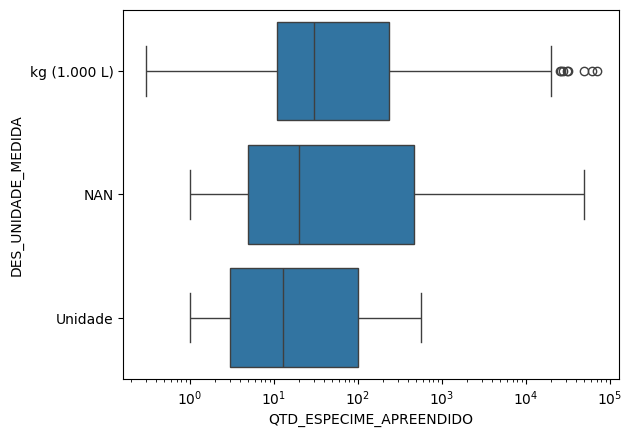

In [ ]:
temp = df[df['GRUPO']=='Pescado'].copy()
temp.loc[(temp['DES_UNIDADE_MEDIDA'].isna()), 'DES_UNIDADE_MEDIDA'] = "NAN"
sns.boxplot(data=temp, x="QTD_ESPECIME_APREENDIDO", y="DES_UNIDADE_MEDIDA", log_scale=True)

<Axes: xlabel='QTD_ESPECIME_APREENDIDO', ylabel='Count'>

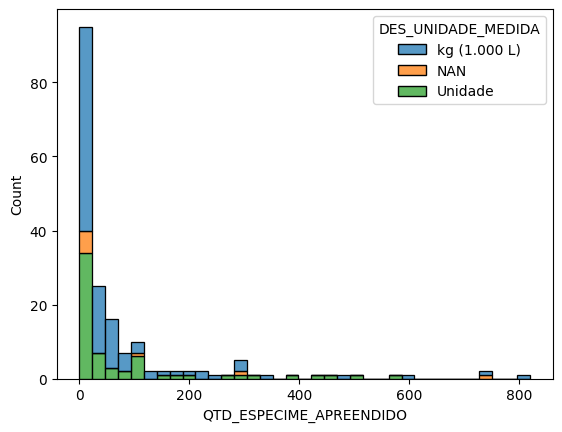

In [ ]:
sns.histplot(data=temp[temp['QTD_ESPECIME_APREENDIDO']<1000], x="QTD_ESPECIME_APREENDIDO",
             hue="DES_UNIDADE_MEDIDA", multiple='stack')

In [ ]:
max_unid = temp.loc[(temp['DES_UNIDADE_MEDIDA']=='Unidade'), 'QTD_ESPECIME_APREENDIDO'].max()
max_unid

574.0

In [ ]:
df.loc[((mask4) & (df['GRUPO']=='Pescado') & (df['QTD_ESPECIME_APREENDIDO'] > max_unid)), 'DES_UNIDADE_MEDIDA'] = 'Unidade'
df.loc[((mask4) & (df['GRUPO']=='Pescado') & (df['QTD_ESPECIME_APREENDIDO'] <= max_unid)), 'DES_UNIDADE_MEDIDA'] = 'kg (1.000 L)'

In [ ]:
analiseTipos(df, 'DES_UNIDADE_MEDIDA')

Num <NAN>: 271
  
DES_UNIDADE_MEDIDA
<class 'str'>      42022
<class 'float'>      271
Name: count, dtype: int64


In [ ]:
mask1 = df['QTD_ESPECIME_APREENDIDO'].isna()
mask2 = df['DES_UNIDADE_MEDIDA'].isna()
mask3 = (mask1 | mask2) & ~(mask1 & mask2) # xor
mask4 = ~(mask1) & mask2 # Quantidade: DESCRITA   //    Unidade: <NAN>
mask5 = mask1 & ~(mask2) # Quantidade: <NAN>      //    Unidade: DESCRITA
mask6 = ~(mask1) & ~(mask2) # ambos NÃO são <NAN>

In [ ]:
df[mask4]

,SEQ_TAD,QTD_ESPECIME_APREENDIDO,DES_UNIDADE_MEDIDA,DESCRICAO_PRODUTO,SITUACAO_CARACTERISTICA,TIPO,GRUPO,SEQ_TAXONOMIA,NOME_CIENTIFICO,DES_NOME_POPULAR,...,DAT_TAD,DAT_IMPRESSAO,CPF_CNPJ_PESSOA_APREENSAO,COD_MUNICIPIO,NOM_MUNICIPIO,SIG_UF,DES_LOCALIZACAO,NUM_LONGITUDE_TAD,NUM_LATITUDE_TAD,VALOR_TAD
17775,1400518,2.0,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,Papagaio,...,2004-06-21 15:45:00,NaN,NaN,3200607.0,Aracruz,ES,Br 101GuaranaAracruz,NaN,NaN,NaN
17777,1400500,2.0,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,Papagaio,...,2004-07-08 08:30:00,NaN,NaN,3201308.0,Cariacica,ES,Rua Itaguaçu 56Nova Brasilia Cariacica,NaN,NaN,NaN
17781,1400498,1.0,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,Papagaio,...,2004-06-22 10:30:00,NaN,NaN,3205309.0,Vitória,ES,Alameda Carmem Rosa da Fonseca 127Santo Antoni...,NaN,NaN,NaN
17837,1400402,1.0,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,Papagaio,...,2004-02-04 11:05:00,NaN,NaN,3201209.0,Cachoeiro de Itapemirim,ES,Rua Para nº15Santo Antonio Cachoeiro de Itapem...,0,0,NaN
17849,1400396,1.0,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,Arara-de-barriga-amarela,...,2004-02-03 10:15:00,NaN,NaN,3205309.0,Vitória,ES,Rua Algio Neto 1622Praia do cantoVitoria,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42265,2714,1.0,NaN,Espécime,NaN,NaN,NaN,NaN,NaN,Papagaio,...,2005-11-30 13:30:00,NaN,NaN,5221601.0,Uruaçu,GO,NaN,NaN,NaN,NaN
42267,2702,15.0,NaN,Sub-Produto,NaN,NaN,NaN,NaN,NaN,Pacu,...,2005-07-14 16:00:00,NaN,NaN,5221601.0,Uruaçu,GO,NaN,NaN,NaN,NaN
42268,2527,1.0,NaN,Espécime,Viva,NaN,NaN,NaN,NaN,Curió,...,2005-12-21 11:00:00,NaN,NaN,1100122.0,Ji-Paraná,RO,NaN,NaN,NaN,NaN
42280,2433,1.0,NaN,Espécime,NaN,NaN,NaN,NaN,NaN,Papagaio-campeiro,...,2006-02-06 16:00:00,NaN,NaN,1100155.0,Ouro Preto do Oeste,RO,NaN,NaN,NaN,500.00


In [ ]:
print(f'''xor:\t\t\t{len(df[mask3])}
QTD!=NA & UND=NA:\t{len(df[mask4])}
QTD=NA & UND!=NA:\t{len(df[mask5])}''')

xor:			266
QTD!=NA & UND=NA:	263
QTD=NA & UND!=NA:	3


<Axes: ylabel='Density'>

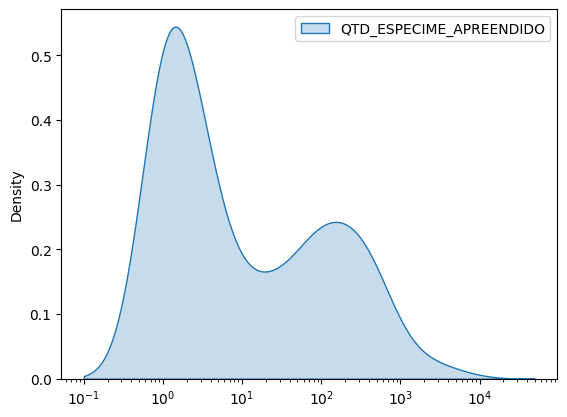

In [ ]:
sns.kdeplot(data=df[mask4].loc[:, ['QTD_ESPECIME_APREENDIDO']], log_scale=True, fill=True)

<ipython-input-277-940e7505cb8a>:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df[~(mask4)], x='QTD_ESPECIME_APREENDIDO', hue='DES_UNIDADE_MEDIDA',log_scale=True, fill=True)


<Axes: xlabel='QTD_ESPECIME_APREENDIDO', ylabel='Density'>

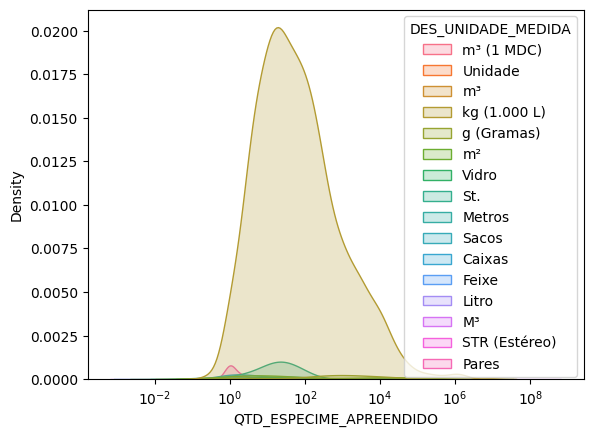

In [ ]:
sns.kdeplot(data=df[~(mask4)], x='QTD_ESPECIME_APREENDIDO', hue='DES_UNIDADE_MEDIDA',log_scale=True, fill=True)

Por enquanto vou transformar todos em Unidade e não pensar muito nisso agora, já que parecem só serem registros antigos, entre 2004 até 2006

Mas também vou tirar os que tem medida mas não tem quantidade, já que são só 3 instâncias

E por último também vou remover os que não tem nem quantidade, e nem medida

In [ ]:
df.loc[(mask4), 'DES_UNIDADE_MEDIDA'] = 'Unidade'

In [ ]:
df = df.drop(df[mask5].index)

In [ ]:
df = df.drop(df[df["DES_UNIDADE_MEDIDA"].isna()].index)



---



In [ ]:
cols = ['TIPO', 'QTD_ESPECIME_APREENDIDO', 'DES_UNIDADE_MEDIDA']#, 'SITUACAO_CARACTERISTICA']
#df[(df['TIPO'] == 'Fauna') & (mask6)].loc[:, cols].groupby(by='DES_UNIDADE_MEDIDA').aggregate(['median', 'count'])#.head()
df.loc[:, cols].groupby(by=['TIPO', 'DES_UNIDADE_MEDIDA']).aggregate(['median','count','mean', 'min', 'max'])

QTD_ESPECIME_APREENDIDO                             \
                                          median count          mean    min   
TIPO  DES_UNIDADE_MEDIDA                                                      
Fauna STR (Estéreo)                         1.50     2      1.500000   1.00   
      St.                                   2.00     2      2.000000   1.00   
      Unidade                               1.00  5169      6.354459   0.20   
      kg (1.000 L)                         50.00    13    726.307692   1.00   
Flora M³                                 3096.00     3  12700.000000  12.00   
      St.                                  10.00     5     19.900000   5.00   
      Unidade                               8.00    15    201.200000   1.00   
      kg (1.000 L)                        172.15     2    172.150000   4.30   
      m²                                    1.68     1      1.680000   1.68   
      m³                                    3.65   265     11.838604   0.01   
Pesca Unidade                              30.00    83    773.469880   1.00   
      g (Gramas)                            3.20     1      3.200000   3.20   
      kg (1.000 L)                         25.00   189   2930.389524   0.30   

                                    
                               max  
TIPO  DES_UNIDADE_MEDIDA            
Fauna STR (Estéreo)           2.00  
      St.                     3.00  
      Unidade              5200.00  
      kg (1.000 L)         3700.00  
Flora M³                  34992.00  
      St.                    59.50  
      Unidade              2091.00  
      kg (1.000 L)          340.00  
      m²                      1.68  
      m³                    563.00  
Pesca Unidade             50000.00  
      g (Gramas)              3.20  
      kg (1.000 L)        70000.00

Agora vou mesclar os tipos 'STR (Estéreo)' e 'St.'

In [ ]:
df = df['DES_UNIDADE_MEDIDA'].apply(lambda x: 'St.' if x=='STR (Estéreo)' else x)

In [ ]:
# fazer um plot (tvz scatter) com os QTD_ESPECIME_APREENDIDO x DES_UNIDADE_MEDIDA
# e os pontos seriam coloridos de acordo com seu GRUPO

Mas para o inverso, ou seja, casos em que a quantidade é ```<NAN>```, já não é tão fácil dar esse palpite, então talvez seja melhor usar outras técnicas. Se possível, não deletar essas entradas

In [ ]:
df[mask5].loc[:, 'TIPO'].value_counts()

TIPO
Fauna    343
Flora     99
Pesca     41
Name: count, dtype: int64

In [ ]:
df['QTD_ESPECIME_APREENDIDO'].apply(lambda x: type(x)==float).all()

True

In [ ]:
df['QTD_ESPECIME_APREENDIDO'].isna().any()

True

In [ ]:
df[df["DES_UNIDADE_MEDIDA"].isna()]

,SEQ_TAD,QTD_ESPECIME_APREENDIDO,DES_UNIDADE_MEDIDA,DESCRICAO_PRODUTO,SITUACAO_CARACTERISTICA,TIPO,GRUPO,SEQ_TAXONOMIA,NOME_CIENTIFICO,DES_NOME_POPULAR,...,DAT_TAD,DAT_IMPRESSAO,CPF_CNPJ_PESSOA_APREENSAO,COD_MUNICIPIO,NOM_MUNICIPIO,SIG_UF,DES_LOCALIZACAO,NUM_LONGITUDE_TAD,NUM_LATITUDE_TAD,VALOR_TAD
1834,1833978,NaN,NaN,Partes,Morto,Pesca,Lagosta,382669.0,Panulirus argus,NaN,...,2023-10-30 13:14:00,NaN,44646122000125.0,2402204.0,Canguaretama,RN,Barraca Miramar,"-35,03474","-6,28709",NaN
1835,1833978,NaN,NaN,Partes,Morto,Pesca,Lagosta,382666.0,Panulirus laevicauda,NaN,...,2023-10-30 13:14:00,NaN,44646122000125.0,2402204.0,Canguaretama,RN,Barraca Miramar,"-35,03474","-6,28709",NaN
17548,1402741,NaN,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,Caboclinho,...,2005-06-04 17:00:00,NaN,NaN,3201209.0,Cachoeiro de Itapemirim,ES,rua walace de melo nº32Jardim itapemirimcachoe...,0,0,NaN
20631,1388308,NaN,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,NaN,...,2005-04-19 11:45:00,NaN,NaN,3205002.0,Serra,ES,Sitio Taquana (Zona Rural) - Taquana - Serra/ES,NaN,NaN,NaN
32261,420658,NaN,NaN,NaN,Agrotóxico,Degradação,NaN,NaN,NaN,NaN,...,2004-06-23 17:50:00,NaN,36063401091.0,4313706.0,Palmeira das Missões,RS,FAZ. VISTA ALEGRE - PALMEIRA DAS MISSOES/RS,NaN,NaN,NaN
32929,370832,NaN,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,NaN,...,2005-01-28 09:45:00,NaN,1385249048.0,4315602.0,Rio Grande,RS,NaN,NaN,NaN,NaN
40827,86471,NaN,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,NaN,...,2006-02-09 15:00:00,NaN,6768300059.0,4321600.0,Tramandaí,RS,NO MUNICIPIO DE OSORIO/RS FOI APREENDIDO 05 CA...,NaN,NaN,NaN
40828,86471,NaN,NaN,NaN,Vivo,Fauna,NaN,NaN,NaN,NaN,...,2006-02-09 15:00:00,NaN,6768300059.0,4321600.0,Tramandaí,RS,NO MUNICIPIO DE OSORIO/RS FOI APREENDIDO 05 CA...,NaN,NaN,NaN


###DESCRICAO_PRODUTO:

In [ ]:
df["MUN_OCOR"].nunique()

591

In [ ]:
df["MUN_OCOR"].isna().any()

False

In [ ]:
view = df[["MUN_OCOR", "COD_MUN_OCOR"]].groupby(by="MUN_OCOR").aggregate("mean")

view["COD_MUN_OCOR"] = view["COD_MUN_OCOR"].apply(lambda x: x in df["COD_MUN_OCOR"].unique())

view[view["COD_MUN_OCOR"] == False]

,COD_MUN_OCOR
MUN_OCOR,
PALMAS,False
PALMEIRA,False
VERA CRUZ,False


In [ ]:
anomalias = view[view["COD_MUN_OCOR"] == False].index

df[df["MUN_OCOR"].isin(anomalias)].loc[:, ["UF_OCOR", "MUN_OCOR", "COD_MUN_OCOR", "DATA_OCOR"]].sort_values(by=["MUN_OCOR", "DATA_OCOR"])

,UF_OCOR,MUN_OCOR,COD_MUN_OCOR,DATA_OCOR
ID,,,,
254,TO,PALMAS,172100,2015-07-25
795,TO,PALMAS,172100,2017-09-29
1301,TO,PALMAS,172100,2018-01-18
2134,PR,PALMAS,411760,2020-11-18
2166,PR,PALMAS,411760,2020-11-30
2167,PR,PALMAS,411760,2020-11-30
2168,PR,PALMAS,411760,2020-12-09
1993,PR,PALMEIRA,411770,2019-12-05
2150,SC,PALMEIRA,421205,2021-01-19


Parece que são cidades de nomes iguais, mas estados diferentes.

* Palmas: TO e PR
* Palmeira: SC e PR
* Vera Cruz: RS e BA

###SITUACAO_CARACTERISTICA:

In [ ]:
df["DATA_OCOR"].isna().any()

True

In [ ]:
df[df["DATA_OCOR"].isna() == True]

,MACRORREG_OCOR,COD_UF_OCOR,UF_OCOR,COD_MUN_OCOR,MUN_OCOR,DATA_OCOR,SE_OCOR,MES_OCOR,ANO_OCOR,MONITORAMENTO_OCOR
ID,,,,,,,,,,
1,CO,52,GO,521100,ITAPIRAPUÃ,NaT,NaN,2.0,2000,1999/2000
2,CO,52,GO,521970,SANTA TEREZINHA DE GOIÁS,NaT,NaN,NaN,2000,1999/2000
3,CO,52,GO,521520,NOVO BRASIL,NaT,NaN,2.0,2000,1999/2000
4,SE,31,MG,310450,ARINOS,NaT,NaN,2.0,2000,1999/2000
5,SE,31,MG,310820,BONFINÓPOLIS DE MINAS,NaT,NaN,4.0,2000,1999/2000
6,SE,31,MG,313862,LIMEIRA DO OESTE,NaT,NaN,7.0,2001,2000/2001
7,S,43,RS,431770,SANTO ANTÔNIO DAS MISSÕES,NaT,NaN,6.0,2001,2000/2001
8,S,43,RS,430865,GARRUCHOS,NaT,NaN,5.0,2001,2000/2001
10,SE,31,MG,315980,SANTA VITÓRIA,NaT,NaN,11.0,2002,2002/2003


###TIPO:

###GRUPO:

###SEQ_TAXONOMIA:

###NOME_CIENTIFICO:

###DES_NOME_POPULAR:

###CITES:

###OBSERVACAO:

###DAT_ALTERACAO:

###ULTIMA_ATUALIZACAO_RELATORIO:

## Pré-análise dos dados (ANTIGO)

In [ ]:
df = pd.read_csv("/content/febre_amarela_macacos.csv", encoding="ISO 8859-1", sep=';', index_col="ID")

O arquivo original foi escrito como ISO 8859-1 ao invés de UTF-8. Uma dos motivos é que a coleta de dados vêm ocorrendo desde 1999

In [ ]:
df.DATA_OCOR = pd.to_datetime(df.DATA_OCOR, dayfirst=True)

(precisa converter o formato das datas para o pandas não lançar avisos)

In [ ]:
df.head(15)

,MACRORREG_OCOR,COD_UF_OCOR,UF_OCOR,COD_MUN_OCOR,MUN_OCOR,DATA_OCOR,SE_OCOR,MES_OCOR,ANO_OCOR,MONITORAMENTO_OCOR
ID,,,,,,,,,,
1,CO,52,GO,521100,ITAPIRAPUÃ,NaT,NaN,2.0,2000,1999/2000
2,CO,52,GO,521970,SANTA TEREZINHA DE GOIÁS,NaT,NaN,NaN,2000,1999/2000
3,CO,52,GO,521520,NOVO BRASIL,NaT,NaN,2.0,2000,1999/2000
4,SE,31,MG,310450,ARINOS,NaT,NaN,2.0,2000,1999/2000
5,SE,31,MG,310820,BONFINÓPOLIS DE MINAS,NaT,NaN,4.0,2000,1999/2000
6,SE,31,MG,313862,LIMEIRA DO OESTE,NaT,NaN,7.0,2001,2000/2001
7,S,43,RS,431770,SANTO ANTÔNIO DAS MISSÕES,NaT,NaN,6.0,2001,2000/2001
8,S,43,RS,430865,GARRUCHOS,NaT,NaN,5.0,2001,2000/2001
9,S,43,RS,431110,JAGUARI,2002-11-14,46.0,11.0,2002,2002/2003


NaN = Not a Number

NaT = Not a Time

In [ ]:
df.dtypes

MACRORREG_OCOR                object
COD_UF_OCOR                    int64
UF_OCOR                       object
COD_MUN_OCOR                   int64
MUN_OCOR                      object
DATA_OCOR             datetime64[ns]
SE_OCOR                      float64
MES_OCOR                     float64
ANO_OCOR                       int64
MONITORAMENTO_OCOR            object
dtype: object

###MACRORREG_OCOR:

In [ ]:
df["MACRORREG_OCOR"].unique()

array(['CO', 'SE', 'S', 'N', 'NE'], dtype=object)

In [ ]:
df["MACRORREG_OCOR"] = df["MACRORREG_OCOR"].astype("category")

In [ ]:
df["MACRORREG_OCOR"].cat.categories

Index(['CO', 'N', 'NE', 'S', 'SE'], dtype='object')

###COD_UF_OCOR:

In [ ]:
df["COD_UF_OCOR"].nunique() == df["UF_OCOR"].nunique()

False

###UF_OCOR:

In [ ]:
df["UF_OCOR"].unique()

array(['GO', 'MG', 'RS', 'DF', 'MS', 'SP', 'TO', 'PR', 'ES', 'PA', 'BA',
       'MT', 'RR', 'RJ', 'RO', 'SC', 'pr', 'AC'], dtype=object)

O Paraná possui 2 siglas, 'PR' e 'pr'

In [ ]:
df['UF_OCOR'] = df['UF_OCOR'].apply(lambda x: x.upper())

In [ ]:
df["UF_OCOR"] = df["UF_OCOR"].astype('category')

In [ ]:
print(df["COD_UF_OCOR"].nunique() == len(df["UF_OCOR"].cat.categories), '\n')
df["UF_OCOR"].value_counts()

True 



UF_OCOR
SP    859
PR    400
RS    307
MG    266
SC    254
RJ     91
ES     81
GO     73
BA     48
DF     27
PA     23
TO     15
MT      8
RR      4
MS      2
RO      1
AC      1
Name: count, dtype: int64

###COD_MUN_OCOR:

In [ ]:
print(df["COD_MUN_OCOR"].nunique())
df["COD_MUN_OCOR"].nunique() == df["MUN_OCOR"].nunique()

594


False

In [ ]:
df["COD_MUN_OCOR"].isna().any()

False

###MUN_OCOR:

In [ ]:
df["MUN_OCOR"].nunique()

591

In [ ]:
df["MUN_OCOR"].isna().any()

False

In [ ]:
view = df[["MUN_OCOR", "COD_MUN_OCOR"]].groupby(by="MUN_OCOR").aggregate("mean")

view["COD_MUN_OCOR"] = view["COD_MUN_OCOR"].apply(lambda x: x in df["COD_MUN_OCOR"].unique())

view[view["COD_MUN_OCOR"] == False]

,COD_MUN_OCOR
MUN_OCOR,
PALMAS,False
PALMEIRA,False
VERA CRUZ,False


In [ ]:
anomalias = view[view["COD_MUN_OCOR"] == False].index

df[df["MUN_OCOR"].isin(anomalias)].loc[:, ["UF_OCOR", "MUN_OCOR", "COD_MUN_OCOR", "DATA_OCOR"]].sort_values(by=["MUN_OCOR", "DATA_OCOR"])

,UF_OCOR,MUN_OCOR,COD_MUN_OCOR,DATA_OCOR
ID,,,,
254,TO,PALMAS,172100,2015-07-25
795,TO,PALMAS,172100,2017-09-29
1301,TO,PALMAS,172100,2018-01-18
2134,PR,PALMAS,411760,2020-11-18
2166,PR,PALMAS,411760,2020-11-30
2167,PR,PALMAS,411760,2020-11-30
2168,PR,PALMAS,411760,2020-12-09
1993,PR,PALMEIRA,411770,2019-12-05
2150,SC,PALMEIRA,421205,2021-01-19


Parece que são cidades de nomes iguais, mas estados diferentes.

* Palmas: TO e PR
* Palmeira: SC e PR
* Vera Cruz: RS e BA

###DATA_OCOR:

In [ ]:
df["DATA_OCOR"].isna().any()

True

In [ ]:
df[df["DATA_OCOR"].isna() == True]

,MACRORREG_OCOR,COD_UF_OCOR,UF_OCOR,COD_MUN_OCOR,MUN_OCOR,DATA_OCOR,SE_OCOR,MES_OCOR,ANO_OCOR,MONITORAMENTO_OCOR
ID,,,,,,,,,,
1,CO,52,GO,521100,ITAPIRAPUÃ,NaT,NaN,2.0,2000,1999/2000
2,CO,52,GO,521970,SANTA TEREZINHA DE GOIÁS,NaT,NaN,NaN,2000,1999/2000
3,CO,52,GO,521520,NOVO BRASIL,NaT,NaN,2.0,2000,1999/2000
4,SE,31,MG,310450,ARINOS,NaT,NaN,2.0,2000,1999/2000
5,SE,31,MG,310820,BONFINÓPOLIS DE MINAS,NaT,NaN,4.0,2000,1999/2000
6,SE,31,MG,313862,LIMEIRA DO OESTE,NaT,NaN,7.0,2001,2000/2001
7,S,43,RS,431770,SANTO ANTÔNIO DAS MISSÕES,NaT,NaN,6.0,2001,2000/2001
8,S,43,RS,430865,GARRUCHOS,NaT,NaN,5.0,2001,2000/2001
10,SE,31,MG,315980,SANTA VITÓRIA,NaT,NaN,11.0,2002,2002/2003


###SE_OCOR:

###MES_OCOR:

###ANO_OCOR:

###MONITORAMENTO_OCOR:

# Caso queira baixar o dataset em UTF-8:

Original:

In [ ]:
with open("/content/febre_amarela_macacos (1).csv", "w", encoding="utf-8") as new_dtsus:
  with open("/content/febre_amarela_macacos.csv", "r", encoding="ISO 8859-1") as dtsus:
    new_dtsus.write(dtsus.read())

Tratado:

In [ ]:
df.to_csv(r"/content/febre_amarela_macacos (1).csv")